<a href="https://colab.research.google.com/github/hDn24/DATN-Pose-Detection/blob/feature%2Finit_source/Pose_Detection_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the required libs

In [2]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [9]:
# Load dataset into colab machine
!gdown https://drive.google.com/uc?id=1OMCywlpMWdvnZlSxKLRAcN65wVZhYzAP -O yoga_poses.zip -q

In [10]:
!unzip -q yoga_poses.zip -d '/content'

In [3]:
# Download the model from TF Hub
!wget -q -O model.tflite https://tfhub.dev/google/lite-model/movenet/singlepose/thunder/3?lite-format=tflite

# Initialize a TFLite interpreter using the model downloaded
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

In [4]:
# Confidence score to determine whether a keypoint prediction is reliable.
MIN_CROP_KEYPOINT_SCORE = 0.2

def init_crop_region(image_height, image_width):
  """Defines the default crop region.

  The function provides the initial crop region (pads the full image from both
  sides to make it a square image) when the algorithm cannot reliably determine
  the crop region from the previous frame.
  """
  if image_width > image_height:
    box_height = image_width / image_height
    box_width = 1.0
    y_min = (image_height / 2 - image_width / 2) / image_height
    x_min = 0.0
  else:
    box_height = 1.0
    box_width = image_height / image_width
    y_min = 0.0
    x_min = (image_width / 2 - image_height / 2) / image_width

  return {
    'y_min': y_min,
    'x_min': x_min,
    'y_max': y_min + box_height,
    'x_max': x_min + box_width,
    'height': box_height,
    'width': box_width
  }


def torso_visible(keypoints):
  """Checks whether there are enough torso keypoints.
  
  This function checks whether the model is confident at predicting one of the
  shoulders/hips which is required to determine a good crop region.
  """
  return ((keypoints[0, 0, KEYPOINT_DICT['left_hip'], 2] > 
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_hip'], 2] > 
           MIN_CROP_KEYPOINT_SCORE) and
          (keypoints[0, 0, KEYPOINT_DICT['left_shoulder'], 2] > 
           MIN_CROP_KEYPOINT_SCORE or
          keypoints[0, 0, KEYPOINT_DICT['right_shoulder'], 2] > 
           MIN_CROP_KEYPOINT_SCORE))
  

def determine_torso_and_body_range(
    keypoints, target_keypoints, center_y, center_x):
  """Calculates the maximum distance from each keypoints to the center location.
  
  The function returns the maximum distances from the two sets of keypoints:
  full 17 keypoints and 4 torso keypoints. The returned information will be
  used to determine the crop size. See determineCropRegion for more detail.
  """
  torso_joints = ['left_shoulder', 'right_shoulder', 'left_hip', 'right_hip']
  max_torso_yrange = 0.0
  max_torso_xrange = 0.0
  for joint in torso_joints:
    dist_y = abs(center_y - target_keypoints[joint][0])
    dist_x = abs(center_x - target_keypoints[joint][1])
    if dist_y > max_torso_yrange:
      max_torso_yrange = dist_y
    if dist_x > max_torso_xrange:
      max_torso_xrange = dist_x
    
  max_body_yrange = 0.0
  max_body_xrange = 0.0
  for joint in KEYPOINT_DICT.keys():
    if keypoints[0, 0, KEYPOINT_DICT[joint], 2] < MIN_CROP_KEYPOINT_SCORE:
      continue
    dist_y = abs(center_y - target_keypoints[joint][0]);
    dist_x = abs(center_x - target_keypoints[joint][1]);
    if dist_y > max_body_yrange:
      max_body_yrange = dist_y
    
    if dist_x > max_body_xrange:
      max_body_xrange = dist_x

  return [max_torso_yrange, max_torso_xrange, max_body_yrange, max_body_xrange]


def determine_crop_region(
      keypoints, image_height,
      image_width):
  """Determines the region to crop the image for the model to run inference on.
   
  The algorithm uses the detected joints from the previous frame to estimate
  the square region that encloses the full body of the target person and
  centers at the midpoint of two hip joints. The crop size is determined by
  the distances between each joints and the center point.
  When the model is not confident with the four torso joint predictions, the
  function returns a default crop which is the full image padded to square.
  """
  target_keypoints = {}
  for joint in KEYPOINT_DICT.keys():
    target_keypoints[joint] = [
      keypoints[0, 0, KEYPOINT_DICT[joint], 0] * image_height,
      keypoints[0, 0, KEYPOINT_DICT[joint], 1] * image_width
    ]  

  if torso_visible(keypoints):
    center_y = (target_keypoints['left_hip'][0] + 
                target_keypoints['right_hip'][0]) / 2;
    center_x = (target_keypoints['left_hip'][1] + 
                target_keypoints['right_hip'][1]) / 2;

    (max_torso_yrange, max_torso_xrange,
      max_body_yrange, max_body_xrange) = determine_torso_and_body_range(
          keypoints, target_keypoints, center_y, center_x)
      
    crop_length_half = np.amax(
        [max_torso_xrange * 1.9, max_torso_yrange * 1.9,
          max_body_yrange * 1.2, max_body_xrange * 1.2])

    tmp = np.array(
        [center_x, image_width - center_x, center_y, image_height - center_y])
    crop_length_half = np.amin(
        [crop_length_half, np.amax(tmp)]);

    crop_corner = [center_y - crop_length_half, center_x - crop_length_half];

    if crop_length_half > max(image_width, image_height) / 2:
      return init_crop_region(image_height, image_width)
    else:
      crop_length = crop_length_half * 2;
      return {
        'y_min': crop_corner[0] / image_height,
        'x_min': crop_corner[1] / image_width,
        'y_max': (crop_corner[0] + crop_length) / image_height,
        'x_max': (crop_corner[1] + crop_length) / image_width,
        'height': (crop_corner[0] + crop_length) / image_height -
            crop_corner[0] / image_height,
        'width': (crop_corner[1] + crop_length) / image_width -
            crop_corner[1] / image_width
      }
  else:
    return init_crop_region(image_height, image_width)


def crop_and_resize(image, crop_region, crop_size):
  """Crops and resize the image to prepare for the model input."""
  boxes=[[crop_region['y_min'], crop_region['x_min'],
          crop_region['y_max'], crop_region['x_max']]]
  output_image = tf.image.crop_and_resize(
      image, box_indices=[0], boxes=boxes, crop_size=crop_size)
  
  return output_image


def run_detector(interpreter, image, crop_region, crop_size):
  """Runs model inferece on the cropped region.
  
  The function runs the model inference on the cropped region and updates the
  model output to the original image coordinate system.
  """
  image_height, image_width, _ = image.shape
  input_image = crop_and_resize(
    tf.expand_dims(image, axis=0), crop_region, crop_size=crop_size)
  input_image = tf.cast(input_image, dtype=tf.float32)

  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()

  # We use the original model for pre-processing, since the TFLite model doesn't
  # include pre-processing.
  interpreter.set_tensor(input_details[0]['index'], input_image.numpy())
  interpreter.invoke()

  keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
  # Update the coordinates.
  for idx in range(17):
    keypoints_with_scores[0, 0, idx, 0] = (
        crop_region['y_min'] * image_height + 
        crop_region['height'] * image_height * 
        keypoints_with_scores[0, 0, idx, 0]) / image_height
    keypoints_with_scores[0, 0, idx, 1] = (
        crop_region['x_min'] * image_width + 
        crop_region['width'] * image_width * 
        keypoints_with_scores[0, 0, idx, 1]) / image_width
        
  return keypoints_with_scores

def detect(interpreter, input_tensor, inference_count=3):
  """Run detection on an input image.
 
  Args:
    interpreter: tf.lite.Interpreter
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.
    inference_count: Number of times the interpreter should run repeatly on the
      same input image to improve detection accuracy.
 
  Returns:
    A dict containing 1 Tensor of shape [1, 1, 17, 3] representing the
    keypoint coordinates and scores.
  """
  image_height, image_width, channel = input_tensor.shape
  # Get the input shape of the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']
 
  # Detect pose using the full input image
  crop_region = init_crop_region(image_height, image_width)
  keypoint_with_scores = run_detector(
    interpreter, input_tensor, crop_region, 
    crop_size=[input_height, input_width]
    )
 
  # Repeatedly using previous detection result to identify the region of
  # interest and only croping that region to improve detection accuracy
  for _ in range(inference_count - 1):
    crop_region = determine_crop_region(
        keypoint_with_scores, image_height, image_width)
    keypoint_with_scores = run_detector(
        interpreter, input_tensor, crop_region, 
        crop_size=[input_height, input_width])

  return keypoint_with_scores

--2021-11-03 13:11:55--  https://cdn.pixabay.com/photo/2014/01/10/13/30/warrior-pose-241611_960_720.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.21.183, 104.18.20.183, 2606:4700::6812:15b7, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.21.183|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 165624 (162K) [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg          100%[===================>] 161.74K  --.-KB/s    in 0.04s   

2021-11-03 13:11:55 (3.90 MB/s) - ‘image.jpeg’ saved [165624/165624]



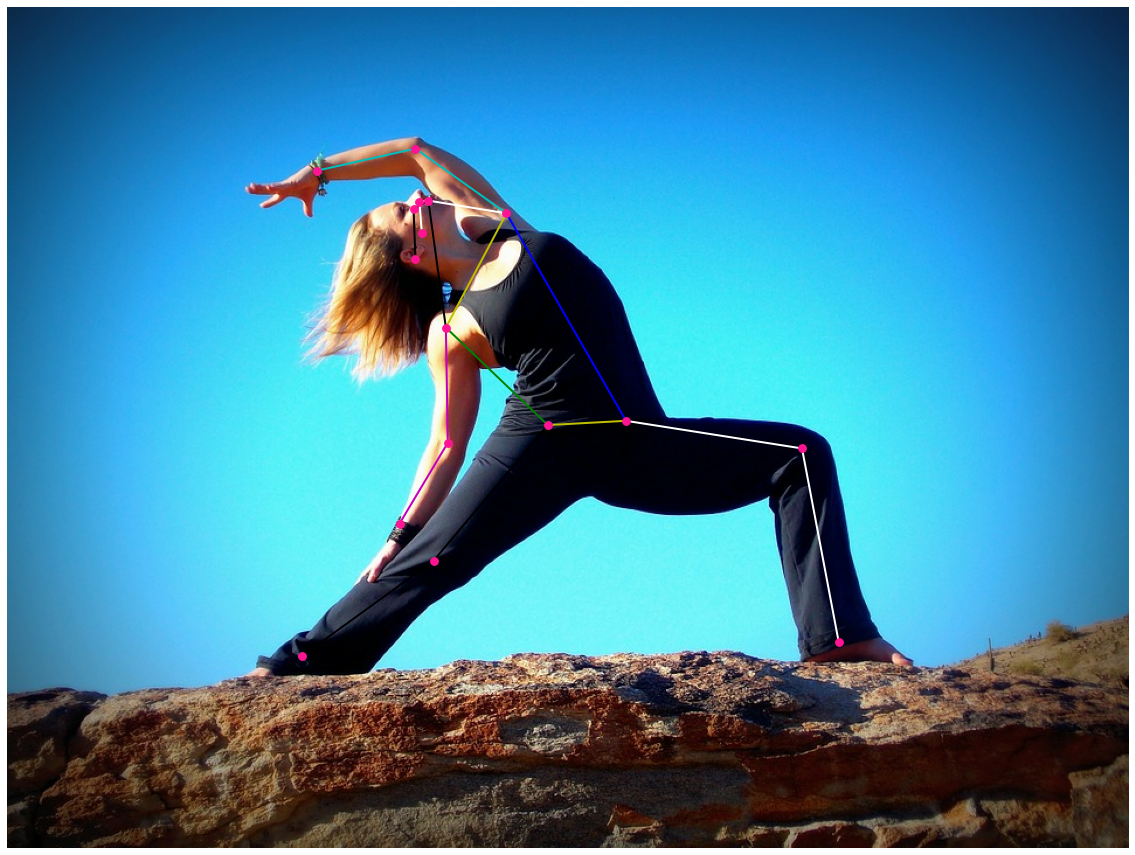

In [8]:
# !wget -O image.jpeg https://q-xx.bstatic.com/xdata/images/hotel/840x460/99231880.jpg?k=7d4b93f26563c1555e7a6df5d1b31c098676fc865e83c7c9f4b1bae52a4fd3d2&o=
!wget -O image.jpeg https://cdn.pixabay.com/photo/2014/01/10/13/30/warrior-pose-241611_960_720.jpg

image = tf.io.read_file('image.jpeg')
image = tf.io.decode_jpeg(image)
keypoint_with_scores = detect(interpreter, image)
output = draw_prediction_on_image(image.numpy().astype(np.uint8),
                                                    keypoint_with_scores, crop_region=None,
                                                    close_figure=False, keep_input_size=True)